In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using Plots

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [2]:
@model [ outbound_message_portal = EmptyPortal() ] function kalman_filter()
     
    x_t_min_mean = datavar(Float64)
    x_t_min_var  = datavar(Float64)
    
    x_t_min ~ NormalMeanVariance(x_t_min_mean, x_t_min_var)
    x_t     ~ NormalMeanVariance(x_t_min, 1.0) + 1.0
    
    γ_shape = datavar(Float64)
    γ_rate  = datavar(Float64)
    γ ~ GammaShapeRate(γ_shape, γ_rate)
    
    y = datavar(Float64)
    y ~ NormalMeanPrecision(x_t, γ) where { q = MeanField() }
    
    return x_t_min_mean, x_t_min_var, x_t_min, x_t, γ_shape, γ_rate, γ, y
end

kalman_filter (generic function with 1 method)

In [16]:
function start_inference(data_stream)
     
    model, (x_t_min_mean, x_t_min_var, x_t_min, x_t, γ_shape, γ_rate, γ, y) = kalman_filter()
    
    x_t_min_prior = NormalMeanVariance(0.0, 1e7)
    γ_prior       = GammaShapeRate(0.001, 0.001)
    
    x_t_stream = Subject(MarginalOrInitialMarginal)
    γ_stream = Subject(MarginalOrInitialMarginal)
    
    x_t_subscribtion = subscribe!(getmarginal(IncludeInitial(), x_t), (x_t_posterior) -> begin
        next!(x_t_stream, x_t_posterior)
        update!(x_t_min_mean, mean(x_t_posterior))
        update!(x_t_min_var, var(x_t_posterior))
    end)
    
    γ_subscription = subscribe!(getmarginal(IncludeInitial(), γ), (γ_posterior) -> begin
        next!(γ_stream, γ_posterior)
        update!(γ_shape, shape(γ_posterior))
        update!(γ_rate, rate(γ_posterior)) 
    end)
    
    setmarginal!(x_t, x_t_min_prior)
    setmarginal!(γ, γ_prior)
    
    data_subscription = subscribe!(data_stream, (d) -> update!(y, d))
    
    return x_t_stream, γ_stream, () -> begin
        unsubscribe!(x_t_subscribtion)
        unsubscribe!(γ_subscription)
        unsubscribe!(data_subscription)
    end
end

start_inference (generic function with 1 method)

In [4]:
mutable struct DataGenerationProcess
    previous :: Float64
    process_noise :: Float64
    observation_noise :: Float64
    history :: Vector{Float64}
    observations :: Vector{Float64}
end

function getnext!(process::DataGenerationProcess)
    next = process.previous
    process.previous = rand(Normal(process.previous, process.process_noise)) + 1.0
    observation = next + rand(Normal(0.0, process.observation_noise))
    push!(process.history, next)
    push!(process.observations, observation)
    return observation
end

function gethistory(process::DataGenerationProcess)
    return process.history
end

function getobservations(process::DataGenerationProcess)
    return process.observations
end

getobservations (generic function with 1 method)

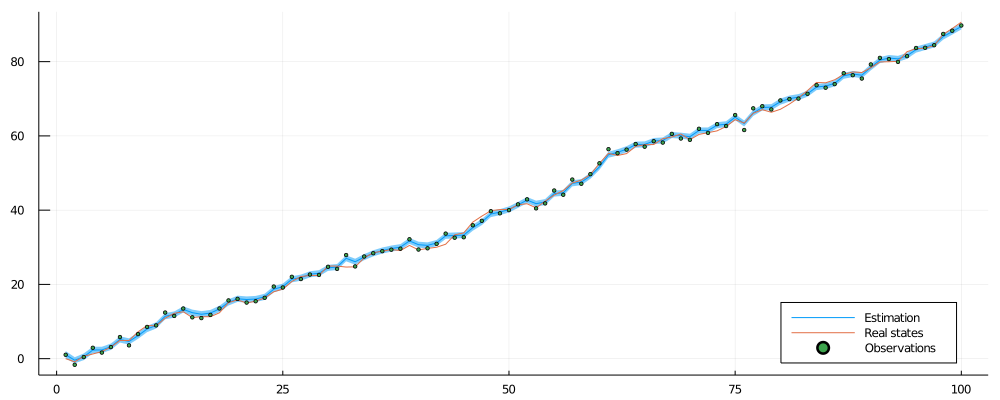

In [21]:
n = 100
process = DataGenerationProcess(0.0, 1.0, 1.0, Float64[], Float64[])
stream = timer(100, 100) |> map_to(process) |> map(Float64, getnext!) |> take(n)

x_t_stream, γ_stream, stop_cb = start_inference(stream);

plot_callback = (posteriors) -> begin
    IJulia.clear_output(true)
    
    p = plot(mean.(posteriors), ribbon = std.(posteriors), label = "Estimation")
    p = plot!(gethistory(process), label = "Real states")    
    p = scatter!(getobservations(process), ms = 2, label = "Observations")
    p = plot(p, size = (1000, 400), legend = :bottomright)
        
    display(p)
end

sub = subscribe!(x_t_stream |> scan(Vector{Marginal}, vcat, Marginal[]) |> map(Vector{Marginal}, reverse), lambda(
    on_next  = plot_callback,
    on_error = (e) -> println(e)
))

In [20]:
stop_cb()
IJulia.clear_output(false);